# Classical Learning

In [ ]:
# Installation of libraries
%pip install elementembeddings==0.6.1 --quiet
%pip install matminer==0.9.3 --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import of modules
import numpy as np  # Numerical operations
import pandas as pd  # DataFrames
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Visualisation
from sklearn.decomposition import PCA  # Principal component analysis (PCA)
from sklearn.cluster import KMeans # k-means clustering
from sklearn.metrics import accuracy_score, confusion_matrix  # Model evaluation
from sklearn.tree import DecisionTreeClassifier  # Decision tree classifier

In [3]:
import matminer
from matminer.datasets.dataset_retrieval import load_dataset

# Use matminer to download the dataset
df = load_dataset('matbench_expt_is_metal')
print(f'The full dataset contains {df.shape[0]} entries. \n')

The full dataset contains 4921 entries. 



## Materials featurisation

[ElementEmbeddings](https://wmd-group.github.io/ElementEmbeddings) is used to featurise the `composition` column. The importance of the pooling method can be tested by generating two sets of features. In the first, the mean of the atomic vectors is used, while in the second, a max pooling method takes the maximum value of each component across all the atomic vectors in the composition.

In [4]:
# Featurise all chemical compositions
from elementembeddings.composition import composition_featuriser

# Compute element embeddings using mean and max pooling
mean_df = composition_featuriser(df["composition"], embedding="magpie", stats=["mean"])
max_df = composition_featuriser(df["composition"], embedding="magpie", stats=["maxpool"])

# Convert "is_metal" column to integer labels (0, 1)
df['is_metal'] = df['is_metal'].astype(int)
mean_df['is_metal'] = df['is_metal']
max_df['is_metal'] = df['is_metal']

# Define feature matrices and target variable
cols_to_drop = ['is_metal', 'formula']

X_mean = mean_df.drop(columns=cols_to_drop, errors='ignore').values
X_max = max_df.drop(columns=cols_to_drop, errors='ignore').values
y = df['is_metal'].values  # Target variable

# Preview first two rows
print("Mean pooling features (first two rows, first 4 columns):")
print(mean_df.iloc[:2, :4])
print("\nMax pooling features (first two rows, first 4 columns):")
print(max_df.iloc[:2, :4])

Featurising compositions...


100%|██████████| 4921/4921 [00:05<00:00, 933.82it/s] 


Computing feature vectors...


100%|██████████| 4921/4921 [00:00<00:00, 454769.53it/s]


Featurising compositions...


100%|██████████| 4921/4921 [00:04<00:00, 1200.92it/s]


Computing feature vectors...


100%|██████████| 4921/4921 [00:00<00:00, 327725.79it/s]


Mean pooling features (first two rows, first 4 columns):
      formula  mean_Number  mean_MendeleevNumber  mean_AtomicWeight
0    Ag(AuS)2    47.400000                  74.6         113.186268
1  Ag(W3Br7)2    46.714286                  81.0         110.931629

Max pooling features (first two rows, first 4 columns):
      formula  maxpool_Number  maxpool_MendeleevNumber  maxpool_AtomicWeight
0    Ag(AuS)2            79.0                     88.0            196.966569
1  Ag(W3Br7)2            74.0                     95.0            183.840000


## $k$-means clustering

### Mean pool

Accuracy: 0.70


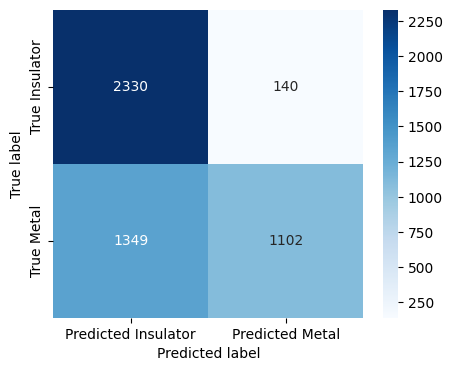

In [10]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=412)
predicted_labels = kmeans.fit_predict(X_mean)

# NOTE: In k-means, the label '0' or '1' is arbitrary — the algorithm just names clusters.
# If accuracy < 0.5, it means the cluster IDs are reversed compared to our target labels,
# so we flip them here for easier comparison. It's not cheating :)
if accuracy_score(y, predicted_labels) < 0.5:
    predicted_labels = 1 - predicted_labels

# Assess performance
accuracy = accuracy_score(y, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y, predicted_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Insulator', 'Predicted Metal'],
            yticklabels=['True Insulator', 'True Metal'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Max pool

Accuracy: 0.63


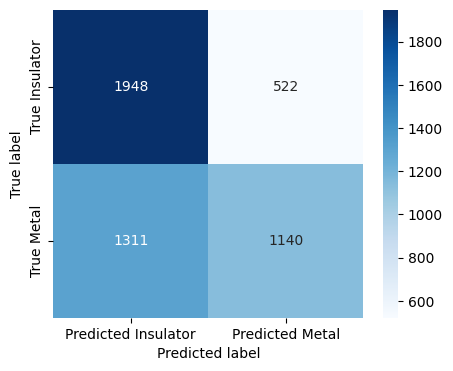

In [11]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=412)
predicted_labels = kmeans.fit_predict(X_max)

# Adjust k-means output to match true labels
if accuracy_score(y, predicted_labels) < 0.5:
    predicted_labels = 1 - predicted_labels

# Assess performance
accuracy = accuracy_score(y, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y, predicted_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Insulator', 'Predicted Metal'],
            yticklabels=['True Insulator', 'True Metal'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Decision Tree Classifiers

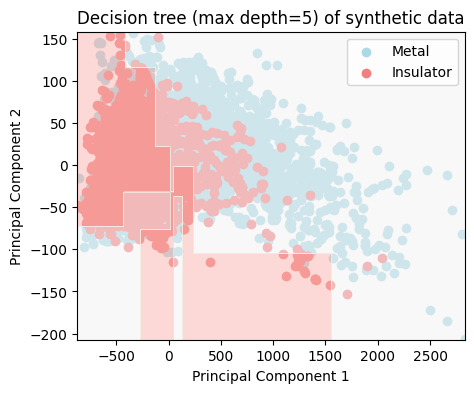

In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

# Perform PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
X_mean_2d = pca.fit_transform(X_mean)

# Step 0: Set the depth of the decision tree
max_tree_depth = 5

# Step 1: Train a decision tree classifier
def train_decision_tree(depth, reduced_data, labels):
    tree_classifier = DecisionTreeClassifier(max_depth=depth, random_state=412)
    tree_classifier.fit(reduced_data, labels)
    return tree_classifier

tree_classifier = train_decision_tree(max_tree_depth, X_mean_2d, y)
predicted_labels = tree_classifier.predict(X_mean_2d)

# Step 2: Create a plot to visualise the decision boundary of the decision tree
plt.figure(figsize=(5, 4))

# Plot the materials labeled as metal (label=1)
plt.scatter(X_mean_2d[y == 1, 0], X_mean_2d[y == 1, 1], c='lightblue', label='Metal')
# Plot the materials labeled as insulator (label=0)
plt.scatter(X_mean_2d[y == 0, 0], X_mean_2d[y == 0, 1], c='lightcoral', label='Insulator')
# Plot the decision boundary of the decision tree classifier
h = 0.1  # step size for the meshgrid
x_min, x_max = X_mean_2d[:, 0].min() - 1, X_mean_2d[:, 0].max() + 1
y_min, y_max = X_mean_2d[:, 1].min() - 1, X_mean_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = tree_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='Pastel1')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Decision tree (max depth={max_tree_depth}) of synthetic data')
plt.legend()

plt.show()

In [19]:
from sklearn.model_selection import cross_val_score

decision_tree = DecisionTreeClassifier(random_state=412)
scores = cross_val_score(decision_tree, X_mean, y, cv=5)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.827879369402831


In [20]:
decision_tree = DecisionTreeClassifier(random_state=412)
scores = cross_val_score(decision_tree, X_max, y, cv=5)
print("Max CV accuracy:", scores.mean())

Max CV accuracy: 0.7524825636581238


In [22]:
X_new_mean = composition_featuriser(["AlGaN2"], embedding="magpie", stats=["mean"])
decision_tree.fit(X_mean, y)
pred_mean = decision_tree.predict(X_new_mean)

if pred_mean == 1:
    print("It's metal")
else:
    print("It's not metal")

100%|██████████| 1/1 [00:00<00:00, 2922.86it/s]

It's not metal
